In [1]:
# Import
import gdown # To download the dataset
import os # Path managing
import json # Json file
import pickle
import re
import cv2 # Another image processing
import concurrent.futures # Do parallel computing
import random
import shutil
import pandas as pd # To create dataset
import numpy as np # image processing
import matplotlib.pyplot as plt # plot image
from PIL import Image # For image processing
from google.colab import files # File download
from numpy.linalg import norm # Normalize
from tqdm import tqdm # Logging the time

# Tensorflow
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import GlobalMaxPooling2D
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from sklearn.neighbors import NearestNeighbors

# Recommendation
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
# from google.colab import files
import matplotlib.image as mpimg

# Data Processing

In [2]:
# Data Download

file_id = '1F0oXhVQfmv3qsISc5stW8EiVEV7N-OF_'
url = f'https://drive.google.com/uc?id={file_id}'

output = '/content/dataset.zip'  # dataset

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1F0oXhVQfmv3qsISc5stW8EiVEV7N-OF_
To: /content/dataset.zip
100%|██████████| 7.57G/7.57G [01:50<00:00, 68.3MB/s]


'/content/dataset.zip'

In [3]:
# Unzip
! unzip "/content/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: IQON3000/947280/3906273/13816689_m.jpg  
  inflating: IQON3000/947280/3906273/34978530_m.jpg  
  inflating: IQON3000/947280/3906273/35875433_m.jpg  
  inflating: IQON3000/947280/3906273/35975920_m.jpg  
  inflating: IQON3000/947280/3906273/35985266_m.jpg  
  inflating: IQON3000/947280/3906273/35990789_m.jpg  
  inflating: IQON3000/947280/3906273/3906273.json  
   creating: IQON3000/947280/3906817/
  inflating: IQON3000/947280/3906817/12774052_m.jpg  
  inflating: IQON3000/947280/3906817/34464144_m.jpg  
  inflating: IQON3000/947280/3906817/35732718_m.jpg  
  inflating: IQON3000/947280/3906817/35792893_m.jpg  
  inflating: IQON3000/947280/3906817/36045882_m.jpg  
  inflating: IQON3000/947280/3906817/36059438_m.jpg  
  inflating: IQON3000/947280/3906817/36060236_m.jpg  
  inflating: IQON3000/947280/3906817/3906817.json  
   creating: IQON3000/947280/3907253/
  inflating: IQON3000/947280/3907253/32676297_m.jpg  
  inflating: 

In [ ]:
# Merge all the json to csv

def process_json_file(file_path):
    try:
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)
            
            setId = json_data['setId']
            user = json_data['user']
            
            processed_items = []
            for item in json_data['items']:
                itemId = item['itemId']
                imgUrl = item['imgUrl']
                price = item['price']
                itemName = item['itemName']
                colors = item['colors']
                expressions = item['expressions']
                category_x_color = item['category x color']
                
                file_path = os.path.join(base_directory, str(user), str(setId), str(itemId) + '_m.jpg')
                
                processed_items.append({
                    'setId': setId,
                    'file_path': file_path,
                    'price': price,
                    'itemName': itemName,
                    'expressions': expressions,
                    'category_x_color': category_x_color})
                
            return processed_items
    except Exception as e:
        print(f"Error processing JSON file: {file_path}")
        print(f"Error message: {str(e)}")
        return []

def convert_json_to_csv(base_directory):
    data = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Collect file paths
        file_paths = []
        for root, dirs, files in os.walk(base_directory):
            for file in files:
                if file.endswith('.json'):  # Process only JSON files
                    file_path = os.path.join(root, file)
                    file_paths.append(file_path)

        # Process files concurrently
        results = executor.map(process_json_file, file_paths)

        # Collect processed items from results
        for processed_items in results:
            data.extend(processed_items)

    df = pd.DataFrame(data)
    return df

base_directory = '/content/IQON3000'
df = convert_json_to_csv(base_directory)


Error processing JSON file: /content/IQON3000/1009734/2957705/2957705.json
Error message: Expecting value: line 1 column 13580 (char 13579)
Error processing JSON file: /content/IQON3000/1009734/2957678/2957678.json
Error message: Expecting ',' delimiter: line 1 column 9458 (char 9457)
Error processing JSON file: /content/IQON3000/1655922/2078263/2078263.json
Error message: Expecting value: line 1 column 1 (char 0)
Error processing JSON file: /content/IQON3000/1655922/3578985/3578985.jsonError processing JSON file: /content/IQON3000/1655922/2040597/2040597.json
Error message: Expecting value: line 1 column 1 (char 0)
Error processing JSON file: /content/IQON3000/1655922/3358590/3358590.json
Error message: Expecting value: line 1 column 1 (char 0)
Error processing JSON file: /content/IQON3000/1655922/2119243/2119243.json
Error message: Expecting value: line 1 column 1 (char 0)

Error message: Expecting value: line 1 column 1 (char 0)
Error processing JSON file: /content/IQON3000/1655922/

In [ ]:
# Save current progress
df.to_csv("dataset1.csv", index=False)

In [ ]:
# Create new columns "category" and "color" in the DataFrame
df[['category', 'color']] = df['category_x_color'].str.split(' × ', expand=True)

# Map the category to clothes, bottom, and accessories
top_categories = ['ニット' , 'ブラウス' , 'コート' , 'ジャケット' , 'カーディガン' , 'パーカー' , 'ダウンジャケット' , 'チュニック' , 'ワンピース']
bottom_categories = ['ロングパンツ' , 'スカート' , 'Tシャツ' , 'ショートパンツ' , 'レッグウェア' , 'ロングスカート']
accessories_categories = ['ピアス' , 'ショルダーバッグ' , '浴衣' , '水着' , 'タンクトップ' , 'パンプス' , 'トップス' , 'ネックレス' , 'サンダル' , 'アンダーウェア' , 'ブレスレット' , 'スニーカー' , 'インテリア' , 'コスメ' , 'ルームウェア' , '腕時計' , 'トートバッグ' , 'ブーツ' , 'クラッチバッグ' , 'ストール' , 'ハット' , 'ハンドバッグ' , 'サングラス' , 'リング' , 'メガネ' , 'ヘアアクセサリー' , 'リュック' , 'キャップ' , 'バッグ' , 'ベルト' , '靴' , '帽子' , 'フレグランス' , 'ニット帽' , 'ネイル' , 'ボストンバッグ' , '小物' , '財布' , '手袋' , 'ボディケア' , 'ブローチ' , '傘' , 'ファッション小物' , 'ステーショナリー' , 'アクセサリー' , 'ルームシューズ'] 
df['category_mapped'] = df['category'].map(lambda x: 'Top' if x in top_categories else ('Bottom' if x in bottom_categories else 'Accessories'))

# Drop the unnecesarry column
df.drop(columns=["category_x_color", "category", "color"], inplace=True)

# Drop the accessories
df = df[df["category_mapped"] != "Accessories"]

# Hapus yang punya setId tunggal
df = df[~df["setId"].isin(df["setId"].value_counts()[df["setId"].value_counts() == 1].index)]

# Save current progress
df.to_csv("dataset2.csv", index=False)

In [ ]:
df.shape

(557899, 6)

In [ ]:
# Ambil sampel untuk melakukan training

# Hapus x% isi dataframe
df = df.sample(frac=0.1, random_state=42)

# Hapus yang punya setId tunggal
df = df[~df["setId"].isin(df["setId"].value_counts()[df["setId"].value_counts() == 1].index)]

# Save progress
df.to_csv("dataset3.csv", index=False)

# dataframe shape
df.shape

(9224, 6)

In [ ]:
# Check whether the image is corrupted or not
def is_image_valid(file_path):
    try:
        Image.open(file_path)
        return True
    except:
        return False

# Check every row
valid_rows = []
for index, row in df.iterrows():
    file_path = row['file_path']
    if os.path.exists(file_path) and is_image_valid(file_path):
        valid_rows.append(row)

# Create valid dataframe
df = pd.DataFrame(valid_rows)

# Save progress
df.to_csv("dataset4.csv", index=False)

# shape
df.shape

(9224, 6)

# Modelling

In [ ]:
# Split dataframe menjadi data latih dan data uji
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Definisikan parameter untuk pra-pemrosesan gambar
image_size = (150, 150)
batch_size = 32

# Pra-pemrosesan gambar dan augmentasi data latih
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalisasi piksel
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='category_mapped',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Pra-pemrosesan gambar data validasi
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='category_mapped',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Membangun model CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Mengompilasi model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', min_delta=0.01)

# Melatih model dengan data latih dan evaluasi pada data validasi
num_epochs = 100
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluasi model pada data uji
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='category_mapped',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print('Akurasi pada data uji:', test_accuracy)

Found 5904 validated image filenames belonging to 2 classes.
Found 1475 validated image filenames belonging to 2 classes.
Epoch 1/100
185/185 [==============================] - 256s 1s/step - loss: 0.5813 - accuracy: 0.7205 - val_loss: 0.5162 - val_accuracy: 0.7112
Epoch 2/100
185/185 [==============================] - 249s 1s/step - loss: 0.4199 - accuracy: 0.8238 - val_loss: 0.3974 - val_accuracy: 0.8285
Epoch 3/100
185/185 [==============================] - 248s 1s/step - loss: 0.3515 - accuracy: 0.8515 - val_loss: 0.3749 - val_accuracy: 0.8380
Epoch 4/100
185/185 [==============================] - 242s 1s/step - loss: 0.2954 - accuracy: 0.8799 - val_loss: 0.3925 - val_accuracy: 0.8583
Epoch 5/100
185/185 [==============================] - 252s 1s/step - loss: 0.2535 - accuracy: 0.9024 - val_loss: 0.3739 - val_accuracy: 0.8495
Epoch 6/100
185/185 [==============================] - 241s 1s/step - loss: 0.1994 - accuracy: 0.9236 - val_loss: 0.3954 - val_accuracy: 0.8603
Epoch 7/100
18

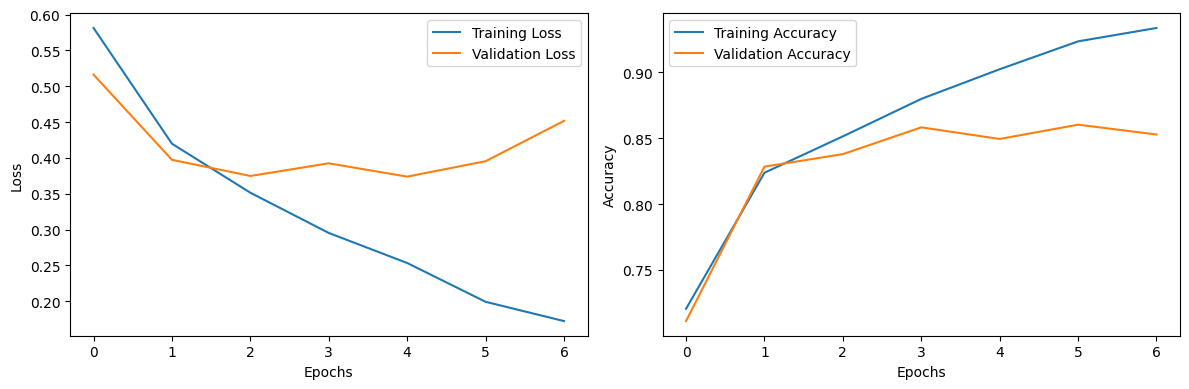

In [ ]:
# Visualisasi loss dan akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Simpan model ke file
model.save('model_top_down.h5')

# Download the model
files.download("model_top_down.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving 8787827_m.jpg to 8787827_m.jpg
1/1 [==============================] - 0s 237ms/step


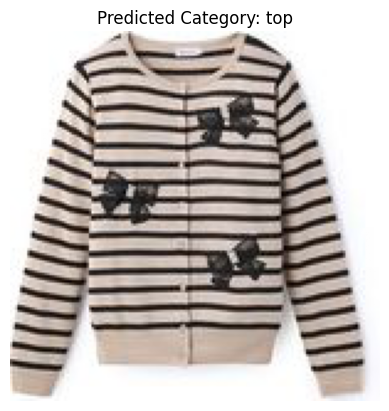

In [ ]:
# Test the model

model = load_model('model_top_down.h5')

# Upload image
uploaded_image = files.upload()

# Load and preprocess the uploaded image
image_path = list(uploaded_image.keys())[0]
image = Image.open(image_path)
image = image.resize((150, 150))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Predict the category
prediction = model.predict(image)
predicted_class = 'top' if prediction[0][0] > 0.5 else 'bottom'

# Display the uploaded image
plt.imshow(image[0])
plt.title(f"Predicted Category: {predicted_class}")
plt.axis('off')
plt.show()

# Recommendation Data Preparation

In [ ]:
# Hapus baris dataframe yang tidak memiliki category_mapped top dan bottom

df_filtered = df.groupby('setId').filter(lambda x: x['category_mapped'].nunique() == 2)

In [ ]:
# Save progress

df_filtered.to_csv("dataset5.csv", index=False)

In [ ]:
df = df_filtered
del df_filtered

# Feature Extraction

In [ ]:
# Buat list directory top dan bottom

top_directory_df = df[df['category_mapped'] == 'Top']
bottom_directory_df = df[df['category_mapped'] == 'Bottom']
top_directory = df[df['category_mapped'] == 'Top']['file_path'].tolist()
bottom_directory = df[df['category_mapped'] == 'Bottom']['file_path'].tolist()

# Save to pickle

pickle.dump(top_directory, open("top_directory.pkl", "wb"))
pickle.dump(bottom_directory, open("bottom_directory.pkl", "wb"))
pickle.dump(top_directory_df, open("top_directory_df.pkl", "wb"))
pickle.dump(bottom_directory_df, open("bottom_directory_df.pkl", "wb"))

In [ ]:
# Feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_model.trainable = False

model = tf.keras.Sequential([
    resnet_model,
    GlobalMaxPooling2D()
])

model.save("feature_extract_model.h5")

def extract_feature(img_path, model):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (150,150))
  img = np.array(img)
  expand_img = np.expand_dims(img, axis=0)
  pre_img = preprocess_input(expand_img)
  result = model.predict(pre_img).flatten()
  normalized = result/norm(result)
  return normalized

In [ ]:
# Feature extraction untuk fitur "top"

feature_extract_model = load_model("feature_extract_model.h5")
top_image_features = [extract_feature(file, feature_extract_model) for file in tqdm(top_directory["file_path"])]

In [ ]:
# Feature extraction untuk fitur "bottom"

feature_extract_model = load_model("feature_extract_model.h5")
bottom_image_features = [extract_feature(file, feature_extract_model) for file in tqdm(bottom_directory["file_path"])]

In [ ]:
# Export the feature to pickle file

pickle.dump(top_image_features, open("top_feature_extraction.pkl", "wb"))
pickle.dump(bottom_image_features, open("bottom_feature_extraction.pkl", "wb"))


files.download("top_feature_extraction.pkl")
files.download("bottom_feature_extraction.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load progress

In [40]:
# Load the latest dataset

df = pd.read_csv("dataset5.csv", index_col=False)

In [41]:
df.head()

,setId,file_path,price,itemName,expressions,category_mapped
0,3639158,/content/IQON3000/2490733/3639158/11414612_m.jpg,"1,360",FALKE / ＜Women's＞ RUNソックス,['アイテム説明FALKEのオリジナリティが凝縮された定番モデル。靴下の踵からつま先部分にか...,Bottom
1,1626772,/content/IQON3000/1055928/1626772/3889104_m.jpg,"5,990",【goods】アームカバービスチェ,"['アイテム説明【送料】商品の合計金額が10,000円（税込）以上の場合は送料無料。10,0...",Top
2,4072418,/content/IQON3000/931999/4072418/42396577_m.jpg,"¥23,760",レースオーバーブラウス,['アイテム説明皺感のある柔らかなシルエットとクラシカルな雰囲気漂うレース切り替えでヴィンテ...,Top
3,3723532,/content/IQON3000/1192297/3723532/14880850_m.jpg,"52,920",YOSOOU / フェイクムートン ダウンジャケット,['アイテム説明ストレッチダウンを提案するブランド「YOSOOU」の、フェイクムートンとスト...,Top
4,4039299,/content/IQON3000/2544785/4039299/13562215_m.jpg,"¥210,965",プリント柄 プリーツスカート,['アイテム説明-【送料】商品のサイズや重量、配送ルートよって異なる\r\n【配送期間】3～...,Bottom


In [42]:
df_copy = df

In [43]:
shutil.rmtree("Dataset")

In [44]:
# Copy every file used in the asset to a new file

destination_path = "Dataset"

os.makedirs(destination_path, exist_ok=True)

for file_path in df_copy["file_path"]:
    for j, file_path_copy in enumerate(df_copy["file_path"]):
        destination_file_path = os.path.join(destination_path, os.path.basename(file_path_copy))
        shutil.copy(file_path_copy, destination_file_path)
        df_copy.at[j, "file_path"] = destination_file_path

SameFileError: ignored

In [45]:
df_copy.head()

,setId,file_path,price,itemName,expressions,category_mapped
0,3639158,Dataset/11414612_m.jpg,"1,360",FALKE / ＜Women's＞ RUNソックス,['アイテム説明FALKEのオリジナリティが凝縮された定番モデル。靴下の踵からつま先部分にか...,Bottom
1,1626772,Dataset/3889104_m.jpg,"5,990",【goods】アームカバービスチェ,"['アイテム説明【送料】商品の合計金額が10,000円（税込）以上の場合は送料無料。10,0...",Top
2,4072418,Dataset/42396577_m.jpg,"¥23,760",レースオーバーブラウス,['アイテム説明皺感のある柔らかなシルエットとクラシカルな雰囲気漂うレース切り替えでヴィンテ...,Top
3,3723532,Dataset/14880850_m.jpg,"52,920",YOSOOU / フェイクムートン ダウンジャケット,['アイテム説明ストレッチダウンを提案するブランド「YOSOOU」の、フェイクムートンとスト...,Top
4,4039299,Dataset/13562215_m.jpg,"¥210,965",プリント柄 プリーツスカート,['アイテム説明-【送料】商品のサイズや重量、配送ルートよって異なる\r\n【配送期間】3～...,Bottom


In [46]:
len(os.listdir("Dataset"))

5660

In [47]:
import zipfile

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

folder_path = "Dataset"
zip_path = "Dataset.zip"

zip_folder(folder_path, zip_path)

# Download the zip file
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
df_copy.to_csv("dataset6.csv", index=False)

In [49]:
files.download("dataset6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Recommend model
def recommend(features,feature_list):
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
    neighbors.fit(feature_list)

    distances, indices = neighbors.kneighbors([features])

    return indices

In [ ]:
# Load all the model and extracted features

model_top_down = load_model("model_top_down.h5")
model_extraction = load_model("feature_extract_model.h5")

top_feature_list = np.array(pickle.load(open("top_feature_extraction.pkl", "rb")))
bottom_feature_list = np.array(pickle.load(open("bottom_feature_extraction.pkl", "rb")))

top_filenames = pickle.load(open('top_directory.pkl', "rb"))
bottom_filenames = pickle.load(open("bottom_directory.pkl", "rb"))

top_filenames_df = pickle.load(open('top_directory_df.pkl', 'rb'))
bottom_filenames_df = pickle.load(open('bottom_directory_df.pkl', 'rb'))

In [ ]:
# Upload image

# Create the folder if it doesn't exist
folder_path = '/content/upload'
os.makedirs(folder_path, exist_ok=True)

# Upload image
uploaded_image = files.upload()

# Save the uploaded image to the folder
image_path = list(uploaded_image.keys())[0]
new_image_path = os.path.join(folder_path, image_path)
shutil.move(image_path, new_image_path)

Saving 9059734_m.jpg to 9059734_m.jpg


'/content/upload/9059734_m.jpg'

1/1 [==============================] - 0s 394ms/step


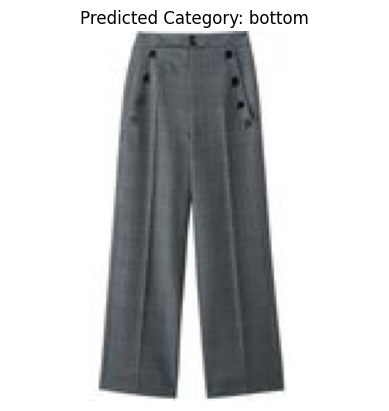

In [ ]:
# Load and preprocess the uploaded image
image_path = new_image_path
image = Image.open(image_path)
image = image.resize((150, 150))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Predict the category
prediction = model_top_down.predict(image)
predicted_class = 'top' if prediction[0][0] > 0.5 else 'bottom'

# Display the uploaded image
plt.imshow(image[0])
plt.title(f"Predicted Category: {predicted_class}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 108ms/step


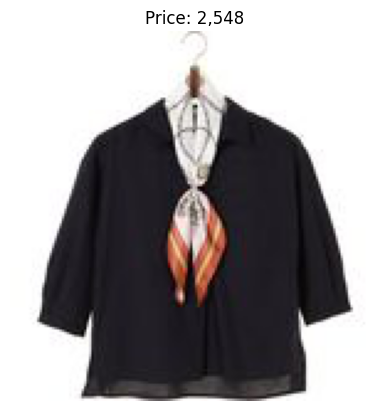

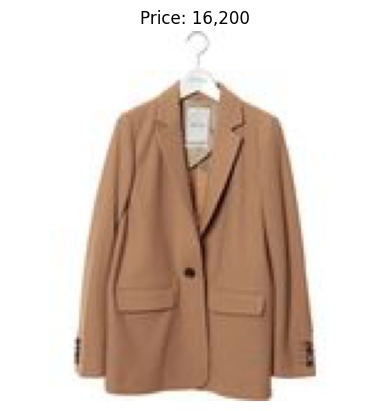

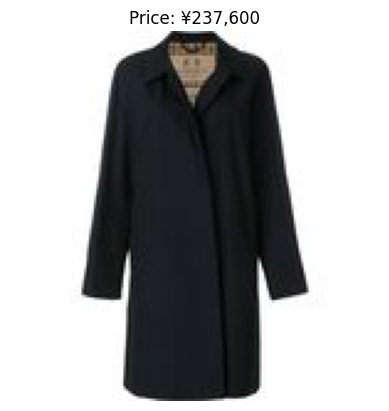

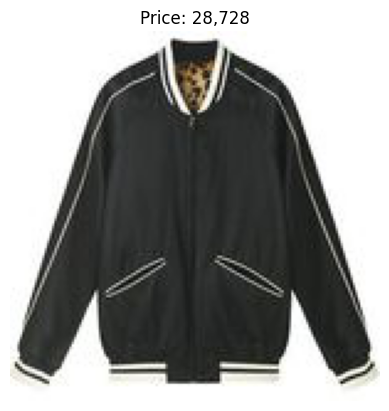

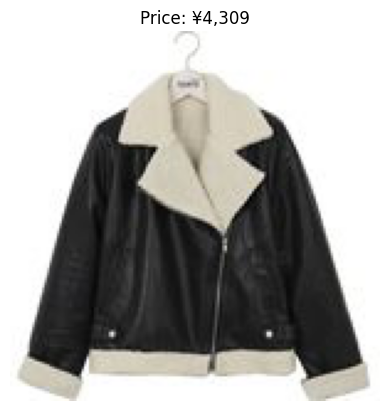

In [ ]:
# Do the recommendation if predicted is top

if predicted_class == 'top':
  features = extract_feature(image_path, model_extraction)
  indices = recommend(features, top_feature_list)

  # Recommendation file_path
  target_file = top_filenames[indices[0][0]]

  # Ambil setId dari rekomendasi
  filtered_df = df.loc[df['file_path'] == target_file]

  set_id = filtered_df["setId"]

  for set in set_id:
    set_id = set
    break
  
  # Teruskan setId ke dataframe bottom
  recommended_path = bottom_filenames_df[bottom_filenames_df['setId'] == set_id]["file_path"]

  for path in recommended_path:
    recommended_path = path
    break

  # Recommend the bottom
  features = extract_feature(recommended_path, model_extraction)
  indices = recommend(features, bottom_feature_list)

  # Print the recommendation
  target_files = [
      bottom_filenames[indices[0][0]],
      bottom_filenames[indices[0][1]],
      bottom_filenames[indices[0][2]],
      bottom_filenames[indices[0][3]],
      bottom_filenames[indices[0][4]]
  ]

  price_output = []

  for file in target_files:
      filtered_df = bottom_filenames_df.loc[bottom_filenames_df['file_path'] == file]
      prices = filtered_df["price"].values
      if len(prices) > 0:
          price_output.append(prices[0])
      else:
          price_output.append('Unknown')

  # Iterate over the target files and display the images with labels
  for i, target_file in enumerate(target_files):
      image_path = target_file
      img = mpimg.imread(image_path)
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Price: {price_output[i]}")
      plt.show()


# If the input is bottom

else:
  features = extract_feature(image_path, model_extraction)
  indices = recommend(features, bottom_feature_list)

  # Recommendation file_path
  target_file = bottom_filenames[indices[0][0]]

  # Ambil setId dari rekomendasi
  filtered_df = df.loc[df['file_path'] == target_file]

  set_id = filtered_df["setId"]

  for set in set_id:
    set_id = set
    break
  
  # Teruskan setId ke dataframe top
  recommended_path = top_filenames_df[top_filenames_df['setId'] == set_id]["file_path"]

  for path in recommended_path:
    recommended_path = path
    break

  # Recommend the top
  features = extract_feature(recommended_path, model_extraction)
  indices = recommend(features, top_feature_list)

  # Print the recommendation
  target_files = [
      top_filenames[indices[0][0]],
      top_filenames[indices[0][1]],
      top_filenames[indices[0][2]],
      top_filenames[indices[0][3]],
      top_filenames[indices[0][4]]
  ]

  price_output = []

  for file in target_files:
      filtered_df = top_filenames_df.loc[top_filenames_df['file_path'] == file]
      prices = filtered_df["price"].values
      if len(prices) > 0:
          price_output.append(prices[0])
      else:
          price_output.append('Unknown')

  # Iterate over the target files and display the images with labels
  for i, target_file in enumerate(target_files):
      image_path = target_file
      img = mpimg.imread(image_path)
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Price: {price_output[i]}")
      plt.show()

In [ ]:
# download semua progress dataset

file_names = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset4.csv', 'dataset5.csv']

for file_name in file_names:
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>